**Problem statment :** Desigh an solution to suggest the next word to an email when they are typing it, to improve user experience and save time.

**Source Data :** https://www.kaggle.com/datasets/wcukierski/enron-email-dataset

In [5]:
import os
import re
import csv
import email
import nltk
import spacy
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions

from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.utils import shuffle
from nltk import bigrams, trigrams

from multiprocessing import pool

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [6]:
chunk_size = 10000
for chunk in pd.read_csv('/content/emails.csv', chunksize=chunk_size):
  chunk.to_csv('sample_mail.csv')

ParserError: Error tokenizing data. C error: EOF inside string starting at row 29729

In [7]:
data = pd.read_csv('/content/sample_mail.csv')
data.head()

,Unnamed: 0,file,message
0,10000,bass-e/_sent_mail/1051.,Message-ID: <7929445.1075854731596.JavaMail.ev...
1,10001,bass-e/_sent_mail/1052.,Message-ID: <25539007.1075854731617.JavaMail.e...
2,10002,bass-e/_sent_mail/1053.,Message-ID: <5807997.1075854731640.JavaMail.ev...
3,10003,bass-e/_sent_mail/1054.,Message-ID: <5164249.1075854731663.JavaMail.ev...
4,10004,bass-e/_sent_mail/1055.,Message-ID: <23780234.1075854731684.JavaMail.e...


In [8]:
def body(messages):
  column = []
  for message in messages:
    msg = email.message_from_string(message)
    column.append(msg.get_payload())
  return column

data['content'] = body(data['message'])
data.head()

,Unnamed: 0,file,message,content
0,10000,bass-e/_sent_mail/1051.,Message-ID: <7929445.1075854731596.JavaMail.ev...,"Hey Kyle,\n\nAttahed is an updated version of ..."
1,10001,bass-e/_sent_mail/1052.,Message-ID: <25539007.1075854731617.JavaMail.e...,Attached is a listing of unresolved Issues bet...
2,10002,bass-e/_sent_mail/1053.,Message-ID: <5807997.1075854731640.JavaMail.ev...,---------------------- Forwarded by Eric Bass/...
3,10003,bass-e/_sent_mail/1054.,Message-ID: <5164249.1075854731663.JavaMail.ev...,We have actually already called Springer to ge...
4,10004,bass-e/_sent_mail/1055.,Message-ID: <23780234.1075854731684.JavaMail.e...,He's doing ok. He doesn't really like his job...


In [22]:
def text_preprocessing(messages):
  messages = messages.lower()
  messages = re.sub('http\S+\s*', ' ', messages)
  messages = re.sub('\s+', ' ', messages)
  messages = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', messages)
  messages = re.sub('@\S+', '  ', messages)
  messages = contractions.fix(messages)
  tokens = [word  for word in messages.split()]
  return ' '.join(tokens)

data['cleaned_content'] = data['content'].apply(lambda x: text_preprocessing(x).split())
data.head()

,Unnamed: 0,file,message,content,cleaned_content
0,10000,bass-e/_sent_mail/1051.,Message-ID: <7929445.1075854731596.JavaMail.ev...,"Hey Kyle,\n\nAttahed is an updated version of ...","[hey, kyle, attahed, is, an, updated, version,..."
1,10001,bass-e/_sent_mail/1052.,Message-ID: <25539007.1075854731617.JavaMail.e...,Attached is a listing of unresolved Issues bet...,"[attached, is, a, listing, of, unresolved, iss..."
2,10002,bass-e/_sent_mail/1053.,Message-ID: <5807997.1075854731640.JavaMail.ev...,---------------------- Forwarded by Eric Bass/...,"[forwarded, by, eric, bass, hou, ect, on, 01, ..."
3,10003,bass-e/_sent_mail/1054.,Message-ID: <5164249.1075854731663.JavaMail.ev...,We have actually already called Springer to ge...,"[we, have, actually, already, called, springer..."
4,10004,bass-e/_sent_mail/1055.,Message-ID: <23780234.1075854731684.JavaMail.e...,He's doing ok. He doesn't really like his job...,"[he, s, doing, ok, he, doesn, t, really, like,..."


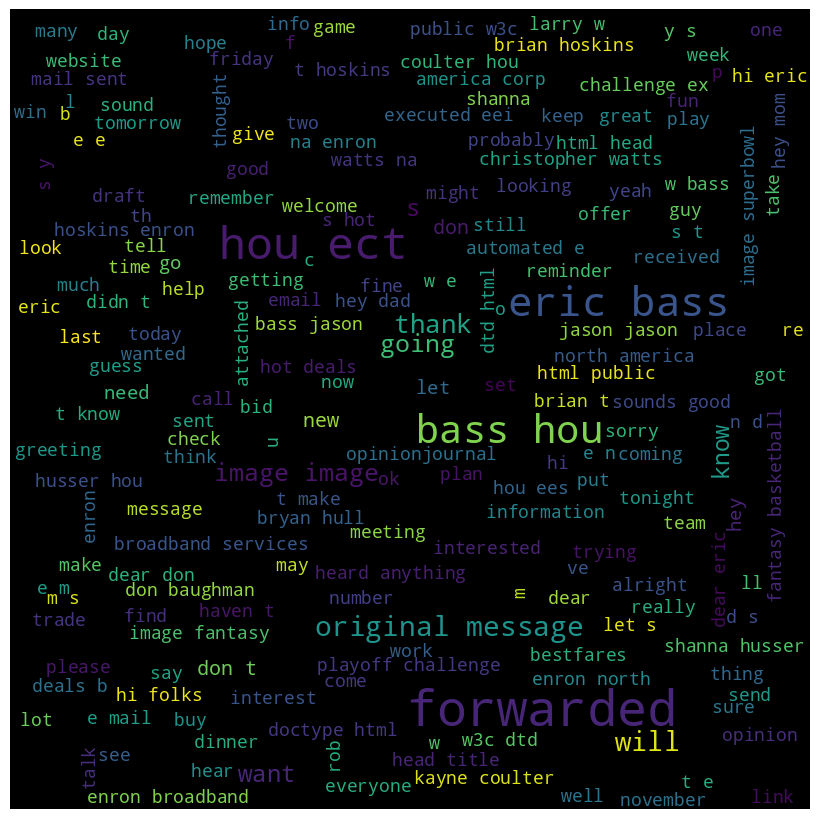

In [23]:
# Visulaize resume content using word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='black',
                      max_font_size=50, min_font_size=10).generate(data['cleaned_content'].to_string())

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

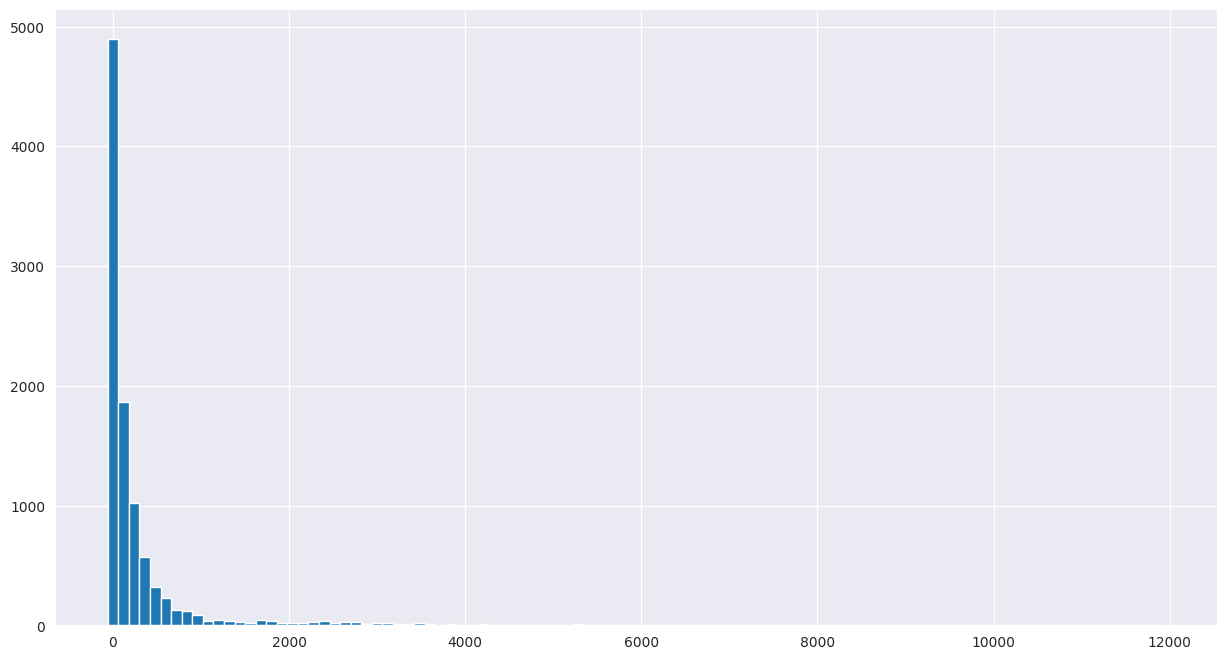

In [24]:
x = list(data['cleaned_content'].apply(lambda x: len(x)))
plt.figure(figsize=(15,8))
plt.hist(x, range=[1, 12000], bins=100, align='left')
plt.show()

In [25]:
for i in range(0, 110, 10):
  print("{}th - percentile of len(text) is {}".format(i, np.percentile(x, i)))
  print("="* 60)

0th - percentile of len(text) is 0.0
10th - percentile of len(text) is 13.0
20th - percentile of len(text) is 31.0
30th - percentile of len(text) is 52.0
40th - percentile of len(text) is 79.0
50th - percentile of len(text) is 116.0
60th - percentile of len(text) is 174.0
70th - percentile of len(text) is 249.0
80th - percentile of len(text) is 369.0
90th - percentile of len(text) is 672.1000000000004
100th - percentile of len(text) is 11632.0


In [26]:
# most comman word
from collections import Counter

def word_count(str):
  count = dict()
  words = str.split()

  for word in words:
    if word in count:
      count[word] += 1
    elif (len(word) > 2):
      count[word] = 1
  return count

most_frequent_word = Counter(word_count(str(data['cleaned_content'].to_string()))).most_common(100)
print('\n'.join(map(str, most_frequent_word)))
del(most_frequent_word)
# most_frequent_word

('...', 2407)
('the,', 1704)
('you,', 1652)
('to,', 1586)
('on,', 1305)
('by,', 1139)
('is,', 1080)
('[forwarded,', 954)
('hou,', 940)
('[i,', 883)
('for,', 877)
('ect,', 868)
('eric,', 834)
('bass,', 813)
('and,', 589)
('are,', 574)
('from,', 567)
('have,', 539)
('this,', 521)
('of,', 510)
('we,', 457)
('that,', 447)
('your,', 409)
('in,', 403)
('message,', 403)
('it,', 369)
('enron,', 339)
('will,', 338)
('09,', 307)
('me,', 296)
('com,', 289)
('image,', 288)
('know,', 282)
('be,', 278)
('at,', 267)
('[hey,', 264)
('[we,', 264)
('[image,', 261)
('going,', 243)
('do,', 241)
('don,', 239)
('out,', 219)
('[original,', 209)
('can,', 208)
('want,', 203)
('[dear,', 202)
('up,', 201)
('am,', 196)
('[hi,', 196)
('[the,', 193)
('just,', 191)
('my,', 189)
('[you,', 186)
('get,', 185)
('[what,', 184)
('not,', 183)
('about,', 182)
('like,', 181)
('was,', 180)
('but,', 178)
('[don,', 176)
('if,', 174)
('[this,', 171)
('01,', 169)
('new,', 168)
('here,', 161)
('t...', 161)
('an,', 159)
('forwarded

Train and test

In [27]:
shuffle_df = data.sample(frac=1, random_state=42)

train_size = int(0.8 * len(shuffle_df))

train_df = shuffle_df[:train_size]
train_df.reset_index(inplace=True, drop=True)

test_df = shuffle_df[train_size:]
test_df.reset_index(inplace=True, drop=True)

In [28]:
df = train_df.copy()
df.head()

,Unnamed: 0,file,message,content,cleaned_content
0,16252,bass-e/sent_items/21.,Message-ID: <7317484.1075840324405.JavaMail.ev...,"Hi Amy,\n\nMy numbers are home: 713-661-2601 a...","[hi, amy, my, numbers, are, home, 713, 661, 26..."
1,14684,bass-e/discussion_threads/540.,Message-ID: <32297811.1075854634826.JavaMail.e...,[IMAGE]\n\n\nFantasy Basketball is here...and ...,"[image, fantasy, basketball, is, here, and, it..."
2,11731,bass-e/all_documents/1342.,Message-ID: <6512683.1075854612407.JavaMail.ev...,I am trying to create the WkD for other areas ...,"[i, am, trying, to, create, the, wkd, for, oth..."
3,14742,bass-e/discussion_threads/593.,Message-ID: <12614702.1075854636417.JavaMail.e...,Fabulous picture. Thanks. Your Sleep Deprive...,"[fabulous, picture, thanks, your, sleep, depri..."
4,14521,bass-e/discussion_threads/393.,Message-ID: <11629968.1075854629707.JavaMail.e...,"Anyone up for half price pizza tonight, say ar...","[anyone, up, for, half, price, pizza, tonight,..."


In [29]:
corpus = df['cleaned_content'].to_list()
corpus[0]

['hi',
 'amy',
 'my',
 'numbers',
 'are',
 'home',
 '713',
 '661',
 '2601',
 'and',
 'cell',
 '713',
 '628',
 '3104',
 'call',
 'me',
 'if',
 'you',
 'have',
 'questions',
 'about',
 'the',
 'offer',
 'letter',
 'eric',
 'bass']

Creating BI-GRAM model

In [51]:
from collections import defaultdict

def build_bigram_model(corpus):
  # create place holder for the model
  bigram_model = defaultdict(lambda : defaultdict(lambda : 0))
  # print(bigram_model)

  # count frequency
  for sentence in corpus:
    for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
      # print(w1, w2)
      bigram_model[w1][w2] += 1

  # conbvert into probabilities
  for w1 in bigram_model:
    total_count = float(sum(bigram_model[w1].values()))
    for w2 in bigram_model[w1]:
      bigram_model[w1][w2] /= total_count

  print(bigram_model['ect'])
  return bigram_model

In [52]:
bigram = build_bigram_model(corpus)

defaultdict(<function build_bigram_model.<locals>.<lambda>.<locals>.<lambda> at 0x7def0f94cb80>, {'ect': 0.4601360893567852, 'cc': 0.10014122480421107, 'gregory': 0.00115547567081782, 'subject': 0.021269311422090983, 'on': 0.05914323618778619, 'chad': 0.006761672444045021, 'kayne': 0.000941498694740446, 'jeffrey': 0.006590490863183121, 'lloyd': 0.000470749347370223, 'karen': 0.0006419309282321222, 'eric': 0.010741644199084178, 'lenine': 0.005520605982796251, 'kamald': 0.00012838618564642445, 'phillip': 0.004921470449779604, 'bryan': 0.012025506055548424, 'harry': 0.002738905293790388, 'o': 0.010784439594299653, 'michael': 0.00808832969572474, 'matthew': 0.010827234989515128, 'melba': 0.0005563401378011726, 'edward': 0.001626225018188043, 'lauri': 0.0012838618564642444, 'thomas': 0.0011982710660332948, 'daren': 0.00231095134163564, 'ccampbel': 0.0005991355330166474, 'jlgaither': 0.0003423631617237985, 'enron': 0.004750288868917704, 'marcelo': 0.00012838618564642445, 'luis': 0.0089870329

In [40]:
len(bigram)

54691

In [60]:
def get_next_word(model, input_string):
    if len(input_string.split()) > 1:
        input_string_ = input_string.split()
        output = dict(model.get(tuple(input_string_[-2:]), {}))  # Using get with a default empty dict
    else:
        output = dict(model.get(input_string, {}))  # Using get with a default empty dict

    # Check if the output is empty
    if not output:
        return f"{input_string}"

    next_word = list({k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)})[0]
    return "{} {}".format(input_string, next_word)


In [63]:
get_next_word(bigram, 'to the form')

'to the form'

In [73]:
get_next_word(bigram, 'dear')

'dear eric'